In [1]:
#Importing needed libraries
import pandas as pd
import cv2
import numpy as np
import itertools
import glob
import random
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import MaxPooling2D, Conv2D, Activation, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

In [3]:
img_size = (120, 120)
epoch = 2
classes = ["Fresh", "Rotten"]
class_number = len(classes)

In [4]:
Train_Data_Path = Path('./data/train_data')
Val_Data_Path = Path('./data/val_data')
Test_Data_Path = Path('./data/test_data')

In [5]:
#changing it to list(.png) path
Train_Img_Path = list(Train_Data_Path.glob(r"**/*g"))
Val_Img_Path = list(Val_Data_Path.glob(r"**/*g"))
Test_Img_Path = list(Test_Data_Path.glob(r"**/*g"))

In [5]:
#defining the label values with the help of the folder name
Train_Img_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Train_Img_Path))
Val_Img_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Val_Img_Path))
Test_Img_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_Img_Path))

In [6]:
#converting all the values to series
Train_Img_Path_Series = pd.Series(Train_Img_Path,name="IMG").astype(str)
Train_Img_Labels_Series = pd.Series(Train_Img_Labels,name="CATEGORY").tolist()

Val_Img_Path_Series = pd.Series(Val_Img_Path,name="IMG").astype(str)
Val_Img_Labels_Series = pd.Series(Val_Img_Labels,name="CATEGORY").tolist()

Test_Img_Path_Series = pd.Series(Test_Img_Path,name="IMG").astype(str)
Test_Img_Labels_Series = pd.Series(Test_Img_Labels,name="CATEGORY").tolist()

In [7]:
def convertlabels(y):
    """converting label string to class value"""
    labels=[]
    for i in range (0,len(y)):
            if y[i]=="Fresh": labels.append(0)
            else: labels.append(1)
    labels=np.array(labels)
    return labels

In [8]:
def convertimage(path):
    """converting path to image"""
    images = []
    for i in path:
        image = cv2.imread(i)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, img_size)
        images.append(image)
    return np.array(images)

In [9]:
X_train = convertimage(Train_Img_Path_Series)
X_val = convertimage(Val_Img_Path_Series)
X_test = convertimage(Test_Img_Path_Series)

y_train = convertlabels(Train_Img_Labels_Series)
y_val = convertlabels(Val_Img_Labels_Series)
y_test = convertlabels(Test_Img_Labels_Series)

In [10]:
#shuffle the train and test values
X_train, y_train = shuffle(X_train, y_train, random_state=10)
X_val, y_val = shuffle(X_val, y_val, random_state=10)
X_test, y_test = shuffle(X_test, y_test, random_state=10)

In [11]:
#converting it into float32
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

In [12]:
#normalizing the values
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [13]:
#printing all the dimensions
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_val shape", X_val.shape)
print("y_val shape", y_val.shape)

print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (10740, 120, 120, 3)
y_train shape (10740,)
X_val shape (632, 120, 120, 3)
y_val shape (632,)
X_test shape (2084, 120, 120, 3)
y_test shape (2084,)


In [14]:
def print_first_ten_images(folder_path, title=None):
    # Get a list of image file names in the folder
    image_files = list(Path(folder_path).glob(r"**/*g"))
    
    image_files = shuffle(image_files)

    first_ten_images = image_files[:6]
    plt.figure(figsize=(12,12))
    c = 1
    print(title)    
    for image_name in first_ten_images:
        image_name = str(image_name)
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, img_size)
        plt.subplot(5,3,c)
        plt.imshow(image)
        plt.ylabel(image_name.split("\\")[2])
        c += 1

Train Set


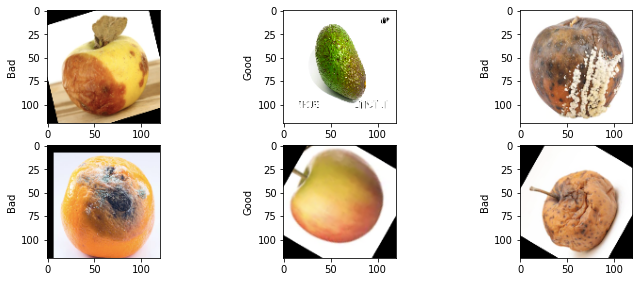

In [15]:
print_first_ten_images("./data/train_data", title="Train Set")

Validation Set


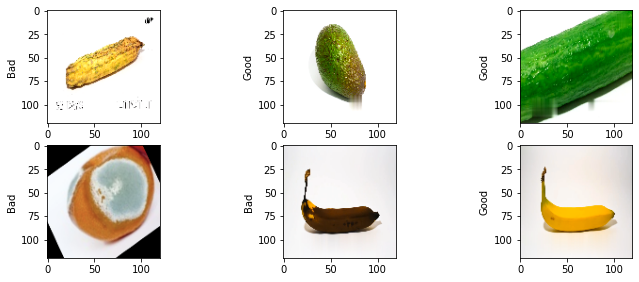

In [16]:
print_first_ten_images("./data/val_data", title="Validation Set")

Test Set


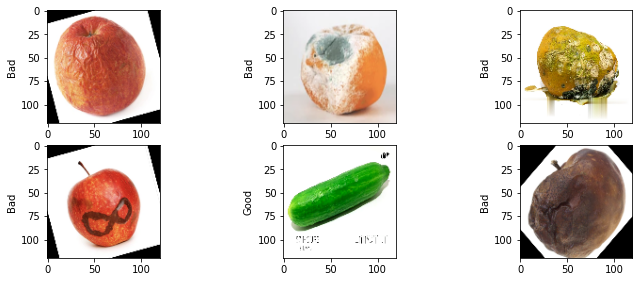

In [17]:
print_first_ten_images("./data/test_data", title="Test Set")

## Modelling

In [18]:
# Let's create callback function
earlystop = EarlyStopping(monitor="loss", patience=5)
l_rate_reduce = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.5, verbose=1, min_lr=0.0001)
callback = [earlystop, l_rate_reduce]

In [19]:
model=Sequential()

model.add(Conv2D(16,(3,3),input_shape=(120, 120, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 activation (Activation)     (None, 118, 118, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 57, 57, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                   

In [21]:
#compiling the model and informing to display accuracy metric
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
history = model.fit(X_train, y_train, epochs=epoch, validation_data=(X_val, y_val), callbacks=callback)

Epoch 1/5


336/336 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9975

In [23]:
model.evaluate(X_train, y_train)

336/336 [==============================] - 480s 1s/step - loss: 0.0996 - accuracy: 0.9609


[0.09957785904407501, 0.9608938694000244]

In [24]:
model.evaluate(X_val, y_val)

20/20 [==============================] - 76s 242ms/step - loss: 0.1466 - accuracy: 0.8908


[0.14659452438354492, 0.8908227682113647]

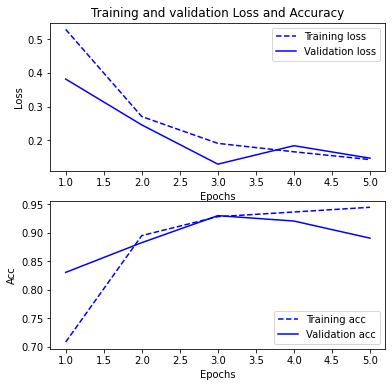

In [25]:
# Training curves

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'b--', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'b--', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [26]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap="Greens"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(class_number)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
#On test dataset
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
target_names = classes

66/66 [==============================] - 70s 216ms/step


In [28]:
#Classification Report
print('Classification Report')
print(classification_report(y_test[:,1], y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Fresh       0.94      0.98      0.96      1187
      Rotten       0.97      0.92      0.94       897

    accuracy                           0.95      2084
   macro avg       0.96      0.95      0.95      2084
weighted avg       0.95      0.95      0.95      2084



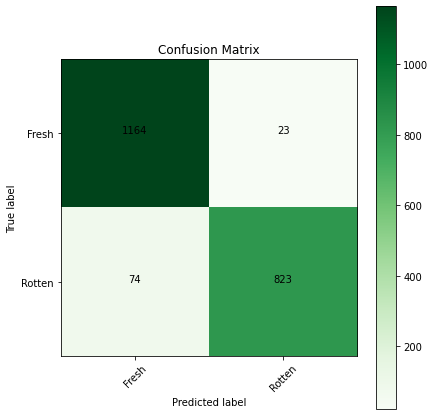

In [29]:
#Confution Matrix
cm = confusion_matrix(y_test[:,1], y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

In [1]:
model.save("model.hdf5")

NameError: name 'model' is not defined

In [31]:
from tensorflow.keras.preprocessing.image import load_img , img_to_array

img = load_img("./Rotten/Image1 - Copy (2).png" , target_size = (120 , 120))
img = img_to_array(img)
img = img.reshape(1 , 120 ,120 ,3)

img = img.astype('float32')
img = img/255.0
result = model.predict(img)
result

1/1 [==============================] - 15s 15s/step


array([[0.9970549 , 0.00360378]], dtype=float32)

In [41]:
dict_result = {}
for i in range(2):
    dict_result[result[0][i]] = classes[i]

res = result[0]
res.sort()
res = res[::-1]
prob = res[:2]
    
prob_result = []
class_result = []
for i in range(1):
    prob_result.append((prob[i]*100).round(2))
    class_result.append(dict_result[prob[i]])

In [42]:
class_result

['Rotten']

In [43]:
prob_result

[99.71]

In [35]:
y_test[:,1]

array([1, 1, 1, ..., 1, 0, 1])

In [36]:
y_pred

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)